# Performance of BinaryNet

In [1]:
% matplotlib inline

import os
import matplotlib.pyplot as plt
from snntoolbox.core.util import wilson_score

from tests.other.googlenet.util import ExpResults, get_std, get_op_at_err

Using Theano backend.


## Parameters and definitions

In [2]:
log_dir = '/home/rbodo/.snntoolbox/data/cifar10'
runlabel_Heaviside = log_dir + '/88.22/log/gui/01'
path_Heaviside = os.path.join(log_dir, 'gui', runlabel_Heaviside, 'log_vars')
runlabel_sign = log_dir + '/88.63/log/gui/02'
path_sign = os.path.join(log_dir, 'gui', runlabel_sign, 'log_vars')

scale = 1e3  # Scale from MOps to GOps

## Performance of ANN and NHP

In [18]:
# Error and number of operations
num_samples = 10000
err_ANN_Heaviside = 100 - 88.42
std_ANN_Heaviside = get_std(err_ANN_Heaviside)
ANN_confidence95_Heaviside = wilson_score(1-err_ANN_Heaviside/100, num_samples) * 100
err_ANN_sign = 100 - 88.97
std_ANN_sign = get_std(err_ANN_sign)
ANN_confidence95_sign = wilson_score(1-err_ANN_sign/100, num_samples) * 100
c_ANN = 1233932288 / 1e9

## Plot number of operations vs time

In [19]:
exp_Heaviside = ExpResults(path_Heaviside, 'SNN Heaviside', '-.', scale=scale)
exp_sign = ExpResults(path_sign, 'SNN sign', ':', 'green', scale=scale)
experiments = [exp_Heaviside, exp_sign]

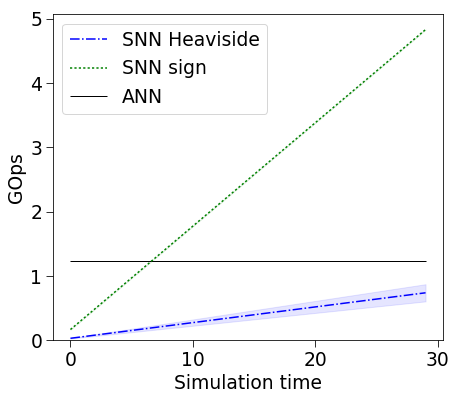

In [20]:
for exp in experiments:
    plt.plot(exp.time, exp.mean_computations_t, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.mean_computations_t-exp.std_computations_t, exp.mean_computations_t+exp.std_computations_t, alpha=0.1, color=exp.color1)
plt.hlines(c_ANN, 0, experiments[0].time[-1], linewidth=1, label='ANN')
plt.ylabel('GOps')
plt.xlabel('Simulation time')
plt.legend()
plt.ylim(0, None)
plt.savefig(os.path.join(log_dir, 'ops_vs_t'), bbox_inches='tight')

## Plot error vs time

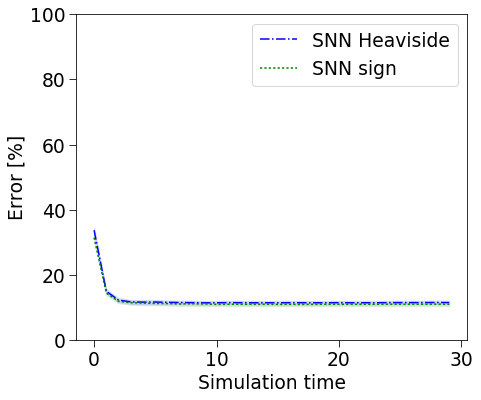

In [21]:
for exp in experiments:
    plt.plot(exp.time, exp.e1_mean, exp.marker, color=exp.color1, markersize=exp.markersize, label=exp.label)
    plt.fill_between(exp.time, exp.e1_mean-exp.e1_confidence95, exp.e1_mean+exp.e1_confidence95, alpha=0.1, color=exp.color1)
plt.ylabel('Error [%]')
plt.xlabel('Simulation time')
plt.ylim(0, 100)
plt.legend()
plt.savefig(os.path.join(log_dir, 'err_vs_t'), bbox_inches='tight')

## Plot error vs operations

In [24]:
op_Heaviside_1 = get_op_at_err(experiments[0].mean_computations_t, experiments[0].e1_mean, err_ANN_Heaviside + 1)
op_sign_1 = get_op_at_err(experiments[1].mean_computations_t, experiments[1].e1_mean, err_ANN_sign + 1)
print("SNN reaches within 1% of ANN top-1 error after {:.2f} ({:.2f}) GOps for 'Heaviside' ('sign').".format(op_Heaviside_1, op_sign_1))

SNN reaches within 1% of ANN top-1 error after 0.08 (0.49) GOps for 'Heaviside' ('sign').


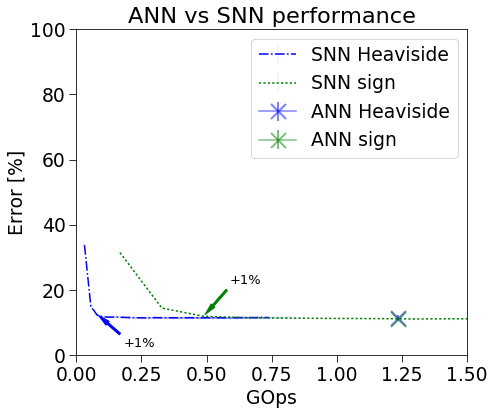

In [23]:
for exp in experiments:
    plt.errorbar(exp.mean_computations_t, exp.e1_mean, xerr=exp.std_computations_t,
                 yerr=exp.e1_confidence95, fmt=exp.marker, label=exp.label, capsize=0, elinewidth=0.1, color=exp.color1)

plt.errorbar(c_ANN, err_ANN_Heaviside, marker='x', label='ANN Heaviside', color=experiments[0].color1, markersize=15,
             yerr=ANN_confidence95_Heaviside, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)
plt.errorbar(c_ANN, err_ANN_sign, marker='x', label='ANN sign', color=experiments[1].color1, markersize=15,
             yerr=ANN_confidence95_sign, elinewidth=2, capthick=2, markeredgewidth=2, alpha=0.5)

plt.annotate('+1%', xy=(op_Heaviside_1, err_ANN_Heaviside+1), xytext=(op_Heaviside_1 + 0.1, err_ANN_Heaviside - 9),
             arrowprops=dict(color=experiments[0].color1, shrink=0.05, width=2, headwidth=5))
plt.annotate('+1%', xy=(op_sign_1, err_ANN_sign+1), xytext=(op_sign_1 + 0.1, err_ANN_sign + 11),
             arrowprops=dict(color=experiments[1].color1, shrink=0.05, width=2, headwidth=5))

plt.xlim(0, 1.5)
plt.ylim(0, 100)
plt.ylabel('Error [%]')
plt.xlabel('GOps')
plt.legend(loc='upper right')
plt.title('ANN vs SNN performance')
plt.savefig(os.path.join(log_dir, 'err_vs_ops'), bbox_inches='tight')